# Next steps: Model development and evaluation

With the data exploration and preprocessing completed in the EDA notebook, the focus now shifts to building, fine-tuning, and evaluating predictive models for the Bank Marketing Dataset. The objective is to leverage the cleaned and prepared data to accurately predict whether a client will subscribe to a term deposit.

## Objetives

1. **Model selection**: Explore and implement a variety of machine learning algorithms suitable for binary classification, including:
    - Decision Trees
    - Random Forest
    - Ada Boosted Machine
    - Gradient Boosted Machine (e.g. XGBoost, LightGBM)

2. **Baseline Model**: Begin with a simple model (e.g. Decision Tree) to establish a baseline performance. Use this as a reference for comparing more complex models.

3. **Feature Importance Analysis**: Investigate the contribution of individual features to the predictions, providing insights into the key drivers of client behavior.

4. **Hyperparameter Tuning**: Optimize model performance using grid search or randomized search with cross-validation to identify the best hyperparameters for each algorithm.

5. **Performance evaluation**: Assess models using a combination of evaluation metrics such as:

    - Accuracy
    - Precision, Recall. and F1-score
    - Area Under the ROC (AUC-ROC)
    - Confusion Matrix Analysis

6. **Insights and recommendations**: Use the results to provide actionable recommendations for improving future marketing strategies, focusing on targeting clients most likely to respond positively to campaigns.

This notebook will detail the process from initial model development to final evaluation, culminating in the selection of the best-performing model and the extraction of meaningful business insights.

##  Model selection and baseline model

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./data/final_data.csv',sep='|')

In [3]:
data.sample()

,contact,housing,poutcome,job,loan,month,marital,default,education,age,previous,balance,day_of_week,campaign,duration,y
13255,cellular,no,unknown,management,yes,jul,single,no,unknown,28,0,81,8,1,158,no


In [4]:
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','poutcome']
numerical_columns = ['day_of_week','age','balance','campaign','duration']
target = 'y'

In [5]:
# Split the dataset into training and test sets
X, y = data.drop(columns=['y']), data['y'].map({'yes':1, 'no':0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),  # Standardize numerical columns
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_columns)  # Encode categorical columns
    ]
)

# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbose=0,random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Function to evaluate models
def evaluate_model(name, model):

    # Apply the preprocessing pipeline
    X_preprocessed_train = preprocessor.fit_transform(X_train)
    model.fit(X_preprocessed_train, y_train)
    X_preprocessed_test = preprocessor.transform(X_test)
    y_pred = model.predict(X_preprocessed_test)
    y_proba = model.predict_proba(X_preprocessed_test)[:, 1]
    print(f"--- {name} ---")
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    prec_score = precision_score(y_test, y_pred)
    print(f"Precision: {prec_score:.4f}")
    rec_score = recall_score(y_test, y_pred)
    print(f"Recall: {rec_score:.4f}")
    f1score = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1score:.4f}")
    roc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {roc:.4f}")
    print()
    return {name : {'Accuracy':acc, 'Precision':prec_score, 'Recall':rec_score, 'F1-Score':f1score, 'AUC-ROC':roc}}

# Evaluate each model
results = {}
for name, model in models.items():
    results.update(evaluate_model(name, model))

--- Decision Tree ---
Accuracy: 0.8740
Precision: 0.4626
Recall: 0.4735
F1-Score: 0.4680
AUC-ROC: 0.7003

--- Random Forest ---
Accuracy: 0.9041
Precision: 0.6533
Recall: 0.3847
F1-Score: 0.4842
AUC-ROC: 0.9264

--- XGBoost ---
Accuracy: 0.9020
Precision: 0.6036
Recall: 0.4735
F1-Score: 0.5307
AUC-ROC: 0.9266

--- AdaBoost ---
Accuracy: 0.8987
Precision: 0.6086
Recall: 0.3762
F1-Score: 0.4650
AUC-ROC: 0.9071



In [6]:
results_df = pd.DataFrame(results).T


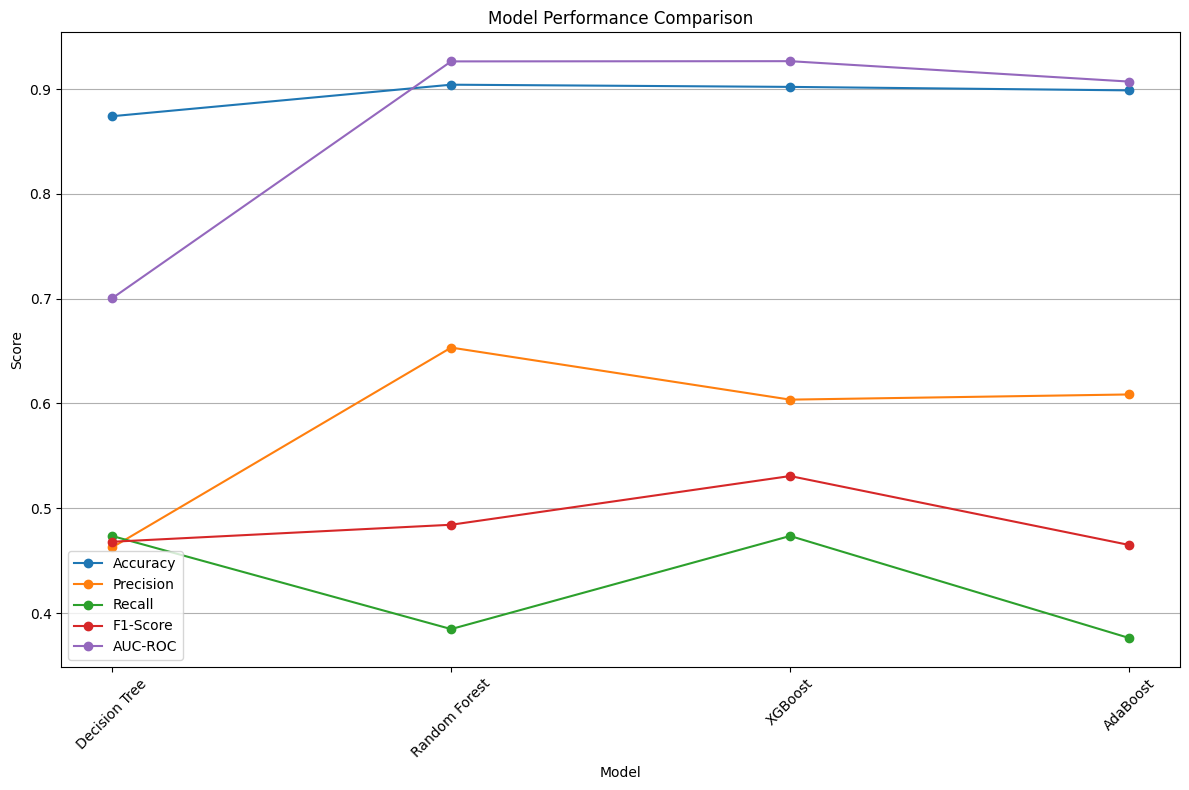

In [7]:
metrics = results_df.columns
x = range(results_df.shape[0])

plt.figure(figsize=(12, 8))
for metric in metrics:
    plt.plot(x, results_df[metric], marker='o', label=metric)


plt.xticks(x, results.keys(), rotation=45)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

To determine the best model, we need to evaluate which one performs best based on your specific objectives and the evaluation metrics provided.

**Metric importance**

1. **Accuracy**: Indicates overall correctness but can be misleading in imbalanced datasets.
2. **Precision**: Measures how many of the predicted positives are actually positive. High precision reduces false positives.
3. **Recall**: Measures how many of the actual positives are correctly identified. High recall reduces false negatives.
4. **F1-score**: A harmonic mean of precision and recall, balancing the two metrics.
5. **AUC-ROC**: Evaluates the model's ability to distinguish between classes across different thresholds.


### Observations

1. **AUC-ROC**:
    - **XGBoost (0.9266)** and **Random Forest (0.9264)** have the highest AUC-ROC, indicating excellent ability to distinguish between classes.
    - **Decission Tree** lags significantly **(0.7003)**, showing it's not a strong classifier in this setup.

2. **F1-Score**:
    - **XGBoost (0.5307)** leads here, which balances precision and recall effectively.
    - **Random Forest** has a lower **F1-Score (0.4842)**, indicating it may struggle with balanced classification compared XGBoost.

3. **Precision and Recall**:
    - **XGBoost** has a balanced precision **(0.6036)** and recall **(0.4735)**.
    - **Random Forest** has higher precision **(0.6533)** but lower recall **(0.3847)**, suggesting it predicts fewer false positives but misses more true positives.

4. **Accuracy**:
    - **Random Forest (0.9041)** edges out slighty over **XGBoost**, but this metric alone is not sufficient for comparision due to class imbalances.



### Conclusion

**XGBoost** is the better model in this case because:

- It achieves the best F1-score (balancing precision and recall).
- It has the highest AUC-ROC, indicating excellent class separation.
- It provides a better balance between precision and recall, which is crucial in scenarios where both false positives and false negatives have significant costs (e.g., marketing campaigns).

##  Feature importance analysis and hyperparameter tunning

In [8]:
# Extract feature importances
X_preprocessed = preprocessor.fit_transform(X_train)
feature_names = (
    numerical_columns +
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_columns).tolist()
)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": models['XGBoost'].feature_importances_
}).sort_values(by="Importance", ascending=False)


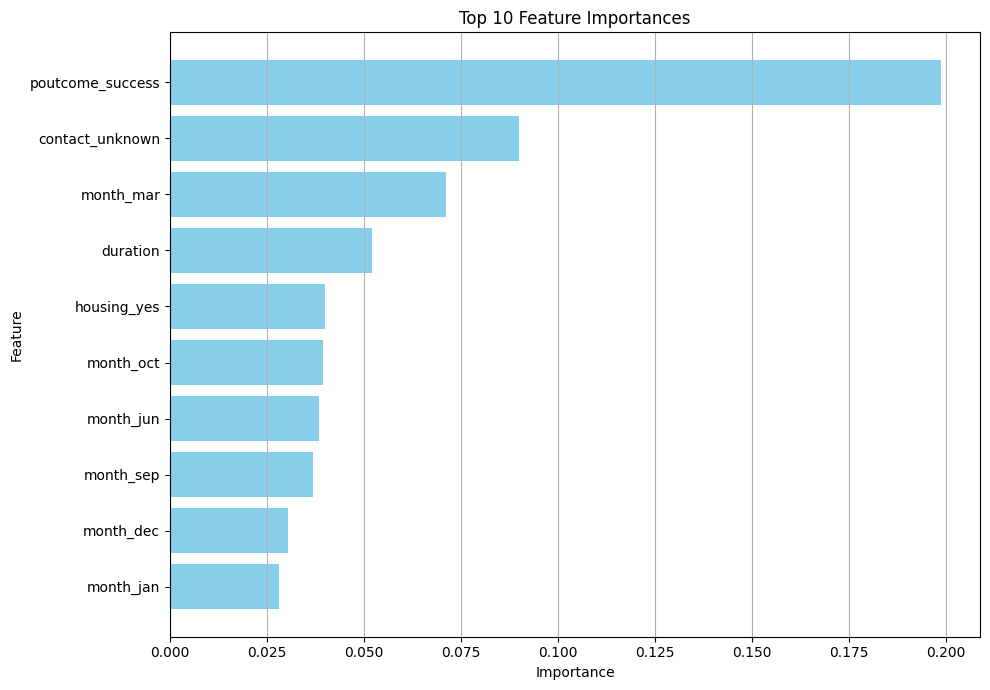

In [9]:
# Plot feature importance
plt.figure(figsize=(10, 7))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], color="skyblue")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis() 
plt.grid(axis="x")
plt.tight_layout()
plt.show()

In [10]:
importance_df.head(10)

,Feature,Importance
37,poutcome_success,0.198781
24,contact_unknown,0.090030
31,month_mar,0.071048
4,duration,0.051980
21,housing_yes,0.040042
34,month_oct,0.039389
30,month_jun,0.038397
35,month_sep,0.036747
26,month_dec,0.030506
28,month_jan,0.028042


### Explanation:

- **importance_type="gain"**: This measures the average improvement in accuracy brought by a feature across all splits it appears in.
- The top 10 features will be visualized in a bar chart for easier interpretation.
- We observed that our most influential categorical variables are **poutcome success**, **contact-unknown**, **month-mar** and numerical variables such as **duration**.

### Hyperparameter Tuning with Bayesian Optimization (Optuna)

In [11]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna optimization
def objective(trial):
    # Hyperparameter search space
    param = {
        "verbosity": 0, 
        "n_estimators": trial.suggest_int("n_estimators", 50, 200, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 0.1),
        "subsample": trial.suggest_uniform("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.7, 1.0),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }
    
    # Create and train the model with suggested parameters
    model = XGBClassifier(**param)
    X_prep_train = preprocessor.fit_transform(X_train)
    model.fit(X_prep_train, y_train)
    
    # Predict and calculate the evaluation metrics
    X_prep_test = preprocessor.fit_transform(X_test)
    y_pred = model.predict(X_prep_test)
    y_proba = model.predict_proba(X_prep_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)
    
    # Return the F1-score (or any other metric you wish to optimize)
    return f1

# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Optimize hyperparameters
study.optimize(objective, n_trials=100)  # You can adjust the number of trials as needed

# Print the best hyperparameters
print("Best hyperparameters found: ", study.best_params)

# Train the model with the best parameters
best_params = study.best_params
best_xgb_model = XGBClassifier(**best_params)
X_prep_train = preprocessor.fit_transform(X_train)
best_xgb_model.fit(X_prep_train, y_train)

# Evaluate the best model on the test set
X_prep_test = preprocessor.fit_transform(X_test)
y_pred = best_xgb_model.predict(X_prep_test)
y_proba = best_xgb_model.predict_proba(X_prep_test)[:, 1]

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

[I 2024-12-06 06:55:31,554] A new study created in memory with name: no-name-e25d99f9-70ab-4338-aca7-bde46a5f72b5
[I 2024-12-06 06:55:32,634] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0010440283971217157, 'subsample': 0.8698869585790693, 'colsample_bytree': 0.8863597198800375}. Best is trial 0 with value: 0.0.
[I 2024-12-06 06:55:33,854] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 3.889899466690512e-05, 'subsample': 0.9984616006026923, 'colsample_bytree': 0.8319178914026715}. Best is trial 0 with value: 0.0.
[I 2024-12-06 06:55:34,513] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.003050807389160549, 'subsample': 0.8294466887596991, 'colsample_bytree': 0.8844434671527404}. Best is trial 0 with value: 0.0.
[I 2024-12-06 06:55:35,047] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 50, 'm

Best hyperparameters found:  {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.06636041084421818, 'subsample': 0.7575099047016497, 'colsample_bytree': 0.7448732038889689}

Evaluation Metrics:
Accuracy: 0.9060
Precision: 0.6344
Recall: 0.4641
F1-Score: 0.5360
AUC-ROC: 0.9275


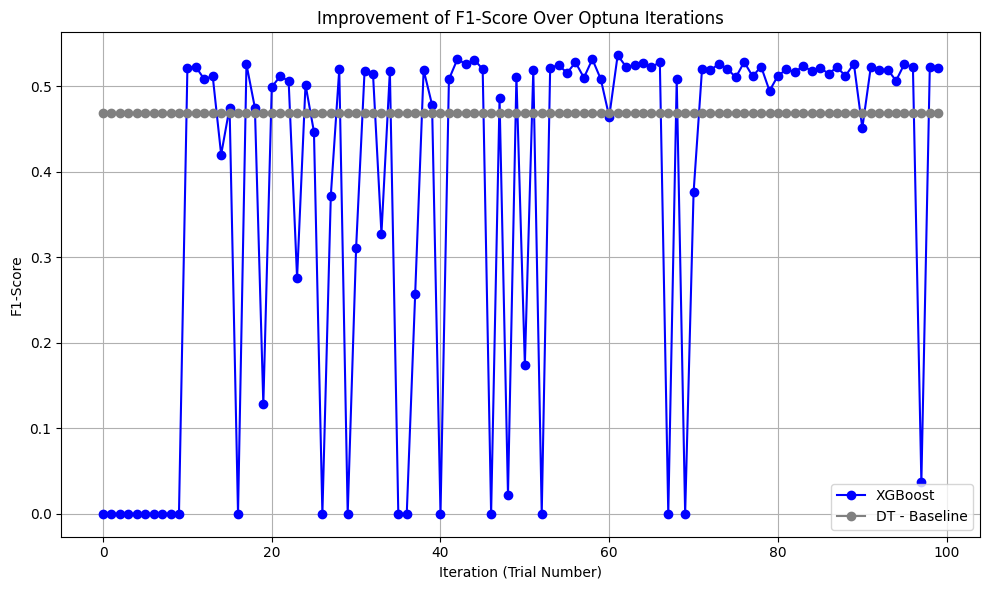

In [12]:
trial_results = study.trials_dataframe()
# Plot the improvement of the F1-score over the iterations
plt.figure(figsize=(10, 6))
plt.plot(trial_results['number'], trial_results['value'], marker='o', linestyle='-', color='b', label='XGBoost')
plt.plot(trial_results['number'],0.4680*np.ones(len(trial_results['number'])),marker='o', linestyle='-', color='gray',label='DT - Baseline')
# Add labels and title
plt.xlabel('Iteration (Trial Number)')
plt.ylabel('F1-Score')
plt.title('Improvement of F1-Score Over Optuna Iterations')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import pickle

with open("model/xgboost_model.pkl", "wb") as file:
    pickle.dump(best_xgb_model, file)
print("Model saved as xgboost_model.pkl")

Model saved as xgboost_model.pkl


In [14]:

with open("model/preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file)
print("Preprocessor saved as preprocessor.pkl")

Preprocessor saved as preprocessor.pkl


In [15]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Pre-trained preprocessor
    ('model', best_xgb_model)                 # Pre-trained model
])

with open("model/pipeline.pkl", "wb") as file:
    pickle.dump(best_xgb_model, file)
print("Pipeline saved as pipeline.pkl")

Pipeline saved as pipeline.pkl


### Best Hyperparameters:

The best hyperparameters found by the Bayesian optimization are:

- **n_estimators = 200**: The model uses 150 boosting rounds (trees)
- **max_depth = 9**: Trees have a maximum depth of 8, controlling the complexity of the model.
- **learning_rate = 0.066**: A moderate learning rate is chosen, balancing between fast convergence and overfiting.
- **subsample = 0.7575**: About 75.75% of the training data is used for each tree, helping prevent overfitting.
- **colsample_bytree = 0.7448**: 74.48% of the features are used per tree, adding regularization.

### Evaluation metrics:

- **Accuracy**: **0.9060** — The model correctly predicts approximately 90.40% of the test samples.
- **Precision**: **0.6344** — About 61.64% of the positive predictions are actually correct. This suggests that the model has a good precision for identifying positive class instances.
- **Recall**: **0.4641** — The model is able to capture about 47.54% of the actual positive instances. This indicates some room for improvement in identifying all relevant positive cases.
- **F1-Score**: **0.5360** — The harmonic mean of precision and recall, indicating a balance between the two metrics. While it's above average, there's still room for optimization.
- **AUC-ROC**: **0.9275** — The area under the Receiver Operating Characteristic curve is high, indicating that the model has a strong ability to distinguish between the positive and negative classes.

### Conclusion

- **Model Performance**: The XGBoost model with the optimized hyperparameters provides a strong performance, with an AUC-ROC of **0.9275**, indicating it has good discriminative power between classes. The F1-Score of **0.5360** suggests that while the model is doing reasonably well, there might still be room for improvement, especially in terms of recall, which is lower compared to precision.

- **Potential Areas for Improvement**:

    - **Recall**: The model's recall is moderate, meaning it may be missing some relevant positive instances. You could experiment with adjusting the classification threshold or focus on improving recall by using techniques like oversampling, undersampling, or further tuning hyperparameters related to regularization.
    - **Feature Engineering**: Further improvement in feature selection or engineering could enhance model performance.


### Final Thoughts:


Overall, the Bayesian optimization approach helped in tuning the model for better performance. However, depending on the specific goal of the classification (e.g., minimizing false positives vs. false negatives), you may want to experiment with further optimization, model types, or thresholds.

If your goal is to maximize recall for the positive class (perhaps in fraud detection or medical diagnosis), you can further adjust the model to prioritize recall. If you’re optimizing for precision (minimizing false positives), the model is already performing quite well.

## Insights and recommendations

### Recommendations for model improvement

- **Optimize Recall**: Since the recall is lower than precision, it may be beneficial to adjust the decision threshold to prioritize recall. This can be done by shifting the decision threshold to be more lenient in classifying positives, thus increasing recall, though this may reduce precision.

- **Feature Engineering**: Investigate whether additional feature engineering could improve the model's performance. This may involve creating interaction terms between features, encoding categorical features differently, or exploring different imputation strategies for missing values.

- **Experiment with Different Models**: Although XGBoost is performing well, it could still be valuable to compare it with other models (e.g., Random Forest, Logistic Regression, or Gradient Boosting Machines like LightGBM) to see if any outperform XGBoost, especially in terms of recall or F1-score.

- **Data Sampling**: If the dataset is imbalanced, consider using techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution, which may help improve recall by making the model more sensitive to the minority class.

- **Further Hyperparameter Tuning**: While Bayesian optimization found a good set of hyperparameters, you can experiment with additional or finer ranges for hyperparameters such as **gamma**, **min_child_weight**, or **scale_pos_weight** (especially if you have class imbalance).

### Conclusion

The XGBoost model with the hyperparameters optimized via Optuna has shown good results in terms of AUC-ROC and accuracy. However, there is still potential to further improve recall and the overall balance between precision and recall. Future steps should include further refinement of the model through threshold adjustments, feature engineering, and perhaps testing different models or advanced sampling techniques to improve performance.

By taking these steps, you can achieve better performance and tailor the model to the specific business or application requirements.